## 7.4 합성곱/풀링 계층 구현하기

### 7.4.1 4차원 배열

앞에서 설명한 대로 CNN에서 계층 사이를 흐르는 데이터는 4차원이다.<br/>
<span style='background-color:#ffdce0'>예를 들어, 데이터의 형상이 (10, 1, 28, 28) 이라면, 이는 높이 28, 너비 28, 채널 1개인 데이터가 10개라는 이야기이다.</span><br/>
이를 파이썬으로 구현하면 다음과 같다.

In [1]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

여기에서 첫번째 데이터에 접근하려면 단순히 x[0]이라고 쓴다.

In [2]:
x[0].shape

(1, 28, 28)

또, 첫번째 데이터의 첫 채널의 공간 데이터에 접근하려면 다음과 같이 적습니다.

In [3]:
x[0, 0].shape

(28, 28)

이처럼 CNN은 4차원 데이터를 다룬다.<br/>
그래서 합성곱 연산의 구현은 복잡해질 것 같지만, <span style='background-color:#ffdce0'>다음 절에서 설명하는 im2col 이라는 '트릭'이 문제를 단순하게 만들어준다.</span>

### 7.4.2 im2col(Image To Column)로 데이터 전개하기

이번 절에서는 for문 대신 <span style='background-color:#fff5b1'>im2col</span>이라는 편의 함수를 사용해 간단하게 구현해보자.

<span style='background-color:#ffdce0'>im2col은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는(펼치는) 함수이다.</span><br/>
아래 그림과 같이 3차원 입력 데이터에 im2col을 적용하면 2차원 행렬도 바뀐다.(정확히는 배치 안의 데이터 수까지 포함한 4차원 데이터를 2차원으로 변환한다.)

<img src="https://compmath.korea.ac.kr/appmath2021/_images/cnn_im2col.png" align="left" width=400 height=400>

im2col은 필터링하기 좋게 입력 데이터를 전개한다.<br/>
구체적으로는 아래 그림과 같이 입력 데이터에서 필터를 적용하는 영역을 한 줄로 늘어놓는다.<br/>
이 전개를 필터를 적용하는 모든 영역에서 수행하는게 im2col이다.

<img src="https://compmath.korea.ac.kr/appmath2021/_images/cnn_im2col_filter.png" align="left" width=400 height=400>

위 그림에서는 보기에 좋게끔 스트라이드를 크게 잡아 필터의 적용 영역이 겹치지 않도록 했지만, 실제 상황에서는 영역이 겹치는 경우가 대부분이다.<br/>
필터 적용 영역이 겹치게 되면 im2col로 전개한 후의 원소 수가 원래 블록의 원소 수보다 많아진다.<br/>
그래서 im2col을 사용해 구현하면 메모리를 더 많이 소비하는 단점이 있다.<br/>
하지만 문제를 행렬 계산으로 만들면 선형 대수 라이브러리를 활용해 효율을 높일 수 있다.

im2col로 입력 데이터를 전개한 다음에는 합성곱 계층의 필터(가중치)를 1열로 전개하고 두 행렬의 곱을 계산하면 된다.

<img src="https://compmath.korea.ac.kr/appmath2021/_images/cnn_im2col_detail.png" align="left" width=600 height=500>

위 그림과 같이 im2col 방식으로 출력한 결과는 2차원 행렬이다.<br/>
CNN은 데이터를 4차원 배열로 저장하므로 2차원인 출력 데이터를 4차원으로 변형한다.

### 7.4.3 합성곱 계층 구현하기

im2col 함수의 인터페이스는 다음과 같다.<br/>

```python
im2col(input_data, filter_h, filter_w, stride=1, pad=0)
```
<br/>

* input_data - (데이터 수, 채널 수, 높이, 너비)의 4차원 배열로 이루어진 입력 데이터
* filter_h - 필터의 높이
* filter_w - 필터의 너비
* stride - 스트라이드
* pad - 패딩

im2col은 '필터 크기', '스트라이드', '패딩'을 고려하여 입력 데이터를 2차원 배열로 전개한다.

In [4]:
import numpy as np
from util import im2col

x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


첫번째는 배치 크기가 1(데이터 1개), 채널은 3개, 높이$\cdot$너비가 7$\times$7의 데이터이고,<br/>
두번째는 배치크기만 10이고 나머지는 첫번째와 같다.<br/>
im2col 함수를 적용한 두 경우 모두 2번째 차원의 원소는 75개(필터의 원소수와 같다. 채널 3개, 5$\times$5 데이터)이다.<br/>
또한, 배치 크기가 1일 때는 im2col의 결과의 크기가 (9, 75)이고 10일때는 그 10배인 (90, 75) 크기의 데이터가 저장된다.

In [5]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_W, -1).transpose(0, 3, 1, 2)
        
        return out

합성곱 계층은 <span style='background-color:#ffdce0'>필터(가중치), 편향, 스트라이드, 패팅을 인수로 받아 초기화한다.</span><br/>
필터는 (FN, C, FH, FW)의 4차원 형상이다.<br/>
여기서 <span style='background-color:#ffdce0'>FN은 필터의 개수, C는 채널, FH는 필터의 높이, FW는 필터의 너비이다.</span>

필터를 전개하는 부분은 위의 그림에서 보듯 각 필터 블록을 한줄로 펼쳐서 세운다.<br/>
이 때 reshape의 두번째 인수는 -1로 지정했는데, 이는 reshape이 제공하는 편의 기능이다.<br/>
reshape에 -1을 지정하면 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 적절히 묶어준다.<br/>
예를 들어, (10, 3, 5, 5)형상을 한 다차원 배열 W의 원소 수는 750개이다.<br/>
이 배열에 reshape(10, -1)을 호출하면 750개의 원소를 10묶음으로, 즉 형상이 (10, 75)인 배열로 만들어준다.

다음으로 forward 구현의 마지막에서는 출력 데이터를 적절한 형상으로 바꿔준다.<br/>
이 때 numpy의 transpose 함수를 사용하는데, 이는 다차원 배열의 축 순서를 바꿔준다.

<img src="https://compmath.korea.ac.kr/appmath2021/_images/cnn_transpose.png" align="left" width=400 height=500>

이상이 합성곱 계층의 forward 구현이다.

### 7.4.4 풀링 계층 구현하기

풀링 계층 구현도 합성곱 계층과 마찬가지로 im2col을 이용해 입력 데이터를 전개한다.<br/>
단, 풀링의 경우에는 채널 쪽이 독립적이라는 점이 합성곱 계층 때와는 다르다.

<img src="https://compmath.korea.ac.kr/appmath2021/_images/cnn_pooling_imp.png" align="left" width=400 height=500>

일단 이렇게 전개한 후, 전개한 행렬에서 행별 최댓값을 구하고 적절한 형상으로 성형하기만 하면 된다.

<img src="https://compmath.korea.ac.kr/appmath2021/_images/cnn_pooling_flow.png" align="left" width=700 height=500>

이상이 풀링 계층의 forward 처리 흐름이다. 파이썬으로 구현하면 다음과 같다.

In [6]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 전개(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        # 최댓값(2)
        out = np.max(col, axis=1)
        
        # 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

풀링 계층 구현은 다음의 세 단계로 진행한다.<br/>
#### 1. 입력 데이터를 전개한다.
#### 2. 행별 최댓값을 구한다.
#### 3. 적절한 모양으로 성형한다.

## 7.5 CNN 구현하기

합성곱 계층과 풀링 계층을 조합하여 CNN을 구현해보자.<br/>
여기에서는 아래 그림과 같은 CNN을 SimpleConvNet 이라는 이름의 클래스로 구현한다.

<img src="https://compmath.korea.ac.kr/appmath2021/_images/cnn_imp.png" align="left" width=700 height=500>

우선 SimpleConvNet의 초기화(init)를 살펴보자. 초기화 할 때는 다음 인수들을 받는다.

#### 초기화 할 때 받는 인수<br/>
1. input_dim $\leftarrow$ 입력 데이터(채널 수, 높이, 너비)의 차원<br/><br/>
2. conv_param $\leftarrow$ 합성곱 계층의 하이퍼파라미터(딕셔너리). 딕셔너리의 키는 아래와 같다.<br/>
(1) filter_num $\leftarrow$ 필터 수<br/>
(2) filter_size $\leftarrow$ 필터 크기<br/>
(3) stride $\leftarrow$ 스트라이드<br/>
(4) pad $\leftarrow$ 패딩<br/><br/>
3. hidden_size $\leftarrow$ 은닉층(완전연결)의 뉴런 수<br/><br/>
4. output_size $\leftarrow$ 출력층(완전연결)의 뉴런 수<br/><br/>
5. weight_init_std $\leftarrow$ 초기화 때의 가중치 표준편차

SimpleConvNet의 초기화는 코드가 좀 길어지므로 세 부분으로 나누어 설명한다. 다음은 그 중 첫번째이다.

```python
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param = {'filter_num' : 30, 'filter_size' : 5, 'stride' : 1, 'pad' : 5}, 
                 hidden_size = 100, output_size = 10, weight_init_std = 0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_stride = conv_param['stride']
        filter_pad = conv_param['pad']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
```
<br/>
여기에서는 초기화 인수로 주어진 합성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼낸다.<br/>
그리고 합성곱 계층의 출력 크기를 계산한다.<br/>
이어서 다음 코드는 가중치 매개변수를 초기화하는 부분이다.

```python
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
```
<br/>
학습에 필요한 매개변수는 1번째 층의 합성곱 계층과 나머지 두 완전연결 계층의 가중치와 편향이다.<br/>
이 매개변수들을 인스턴스 변수 params 딕셔너리에 저장한다.<br/>
마지막으로 CNN을 구성하는 계층들을 생성한다.

```python
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_params['stride'], conv_params['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
```
<br/>
이상이 SimpleConvNet의 초기화이다.<br/>
이렇게 초기화를 마친 후에는 추론을 수행하는 predict 메서드와 손실함수 값을 구하는 loss 메서드를 다음과 같이 구현할 수 있다.

```python
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward()
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
```
<br/>
이 코드에서 인수 x는 입력 데이터, t는 정답 레이블이다.<br/>
이어서 오차역전파법으로 기울기를 구하는 구현은 다음과 같다.

```python
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
```

In [8]:
import pickle
import numpy as np
from collections import OrderedDict
from layers import *
from gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

이제 이 SimpleConvNet으로 MNIST 데이터를 학습해보자.

Saved Network Parameters!


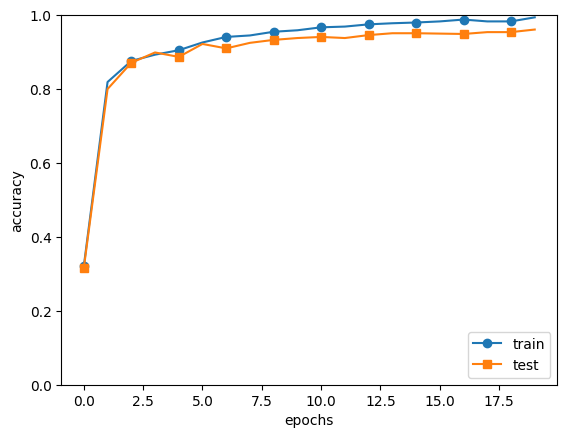

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from trainer import Trainer
from collections import OrderedDict

# 데이터 읽기
# (x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

훈련 데이터에 대한 정확도는 거의 100%이고, 시험 데이터에 대한 정확도는 그보다 조금 낮은 약 95%의 정확도를 보인다.

## 7.6 CNN 시각화하기

### 7.6.1 첫 번째 층의 가중치 시각화하기

앞에서 MNIST 데이터셋으로 간단한 CNN 학습을 해보았는데, 그때 첫 번째 층의 합성곱 계층의 가중치는 형상이 (30, 1, 5, 5)였다.<br/>
필터의 크기가 5$\times$5이고 채널이 1개라는 것은 이 필터를 1채널의 회색조 이미지로 시각화할 수 있다는 뜻이다.

** 무작위(랜덤) 초기화 후의 가중치 **


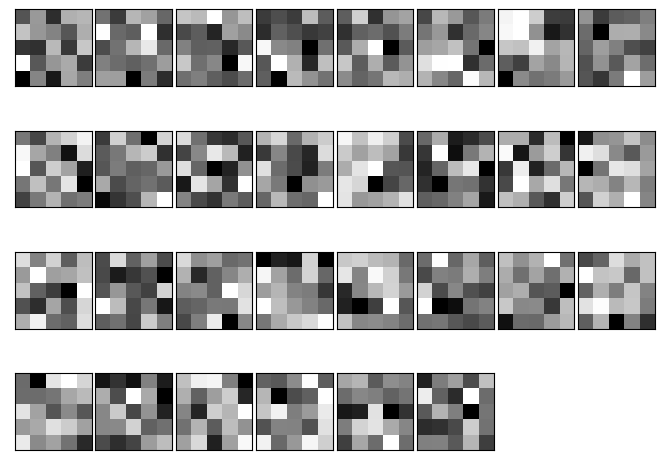

** 학습된 가중치 **


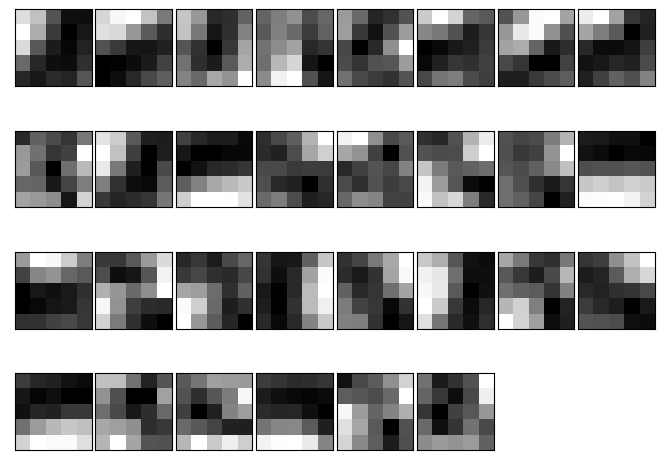

In [17]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
print('** 무작위(랜덤) 초기화 후의 가중치 **')
filter_show(network.params['W1'])

print('** 학습된 가중치 **')
network.load_params("params.pkl")
filter_show(network.params['W1'])

그림과 같이 학습 전 필터는 무작위로 초기화되고있어 흑백의 정도에 규칙성이 없다.<br/>
반면 학습을 마친 필터는 <span style='background-color:#ffdce0'>흰색에서 검은색으로 점차 변화하는 필터와 덩어리가 진 필터 등의 규칙을 띄는 필터가 되었다.</span>

학습을 마친 필터는 <span style='background-color:#ffdce0'>에지(색상이 바뀐 경계선)와 블롭(국소적으로 덩어리진 영역)</span> 등을 보고 있다.<br/>
가령 왼쪽 절반이 흰색이고 오른쪽 절반이 검은색인 필터는 아래 그림과 같이 세로 방향의 에지에 반응하는 필터이다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdm5gQf%2FbtqKfp2Qnmv%2F8dU5txYPjzEzGkawH5aiV0%2Fimg.png" align="left" width=500 height=500>

위 그림은 학습된 필터 2개를 선택하여 입력 이미지에 합성곱 처리를 한 결과로, '필터 1'은 세로 에지에 반응하며 '필터 2'는 가로 에지에 반응하는것을 알 수 있다.

### 7.6.2 층 깊이에 따른 추출 정보 변화

앞 절의 결과는 첫 번째 층의 합성곱 계층을 대상으로 한 것이었다.<br/>
첫 번째 층의 합성곱 계층 에서는 에지나 블롭 등의 저수준 정보가 추출된다면, 겹겹이 쌓인 CNN의 각 계층에서는 어떤 정보가 추출될까?<br/>
딥러닝 시각화에 관한 연구에 따르면, <span style='background-color:#ffdce0'>계층이 깊어질수록 추출되는 정보(정확히는 강하게 반응하는 뉴런)는 더 추상화된다는 것을 알 수 있다.</span>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FxumRT%2FbtqKdGKx1w7%2FLzI6spMarpEDMqcqdrZYIK%2Fimg.png" align="left" width=700 height=500>

위 그그림은 일반 사물 인식(자동차, 개)을 수행한 8층의 CNN이다.<br/>
이 네트워크 구조는 <span style='background-color:#fff5b1'>AlexNet</span>이라 하는데, 합성곱 계층과 풀링 계층을 여러겹 쌓고, 마지막으로 완전연결 계층을 거쳐 결과를 출력하는 구조이다.<br/>
그림에서 블록으로 나타낸 것은 중간 데이터이며, 그 중간 데이터에 합성곱 연산을 연속해서 적용한다.

딥러닝의 흥미로운 점은 <span style='background-color:#ffdce0'>합성곱 계층을 여러 겹 쌓으면, 층이 깊어지면서 더 복잡하고 추상화된 정보가 추출된다는 것이다.</span><br/>
처음 층은 단순한 에지에 반응하고, 이어져 텍스쳐에 만응하고, 더 복잡한 사물의 일부에 반응하도록 변화한다.<br/>
즉, 층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 <span style='background-color:#ffdce0'>고급 정보</span>로 변화해간다.<br/>
다시 말하면, <span style='background-color:#ffdce0'>사물의 의미를 이해하도록 변화</span>하는 것이다.

## 7.7 대표적인 CNN

### 7.7.1 LeNet

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FJI00a%2FbtqKjcVLCJF%2Fyqbjl11F7elZNNxgkLT3F0%2Fimg.png" align="left" width=700 height=500>

<span style='background-color:#fff5b1'>LeNet</span>은 손글씨 숫자를 인식하는 네트워크로, 1998년에 제안되었다.<br/>
그림과 같이 합성곱 계층과 풀링 계층(정확히는 단순히 <span style='background-color:#ffdce0'>원소를 줄이기</span>만 하는 서브샘플링 계층)을 반복하고, 마지막으로 완전연결 계층을 거치면서 결과를 출력한다.

LeNet과 현재의 CNN을 비교하면 몇 가지 면에서 차이가 있다.<br/><br/>
첫 번째 차이는 <span style='background-color:#ffdce0'>활성화 함수</span>이다.<br/>
LeNet은 sigmoid 함수를 사용하는데 반해, 현재는 주로 ReLU를 사용한다.<br/>
두 번째 차이는 <span style='background-color:#ffdce0'>서브 샘플링과 최대 풀링이다.</span><br/>
LeNet은 서브샘플링을 하여 중간 데이터의 크기를 줄이지만 현재는 최대 풀링이 주류이다.

### 7.7.2 AlexNet

LeNet과 비교해 훨씬 최근인 2012년에 발표된 <span style='background-color:#fff5b1'>AlexNet</span>은 딥러닝 열풍을 일으키는데 큰 역할을 하였다.<br/>
아래 그림을 보면 구성은 LeNet과 크게 다르지 않다는 것을 알 수 있다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAXUks%2FbtqKgEMhmAu%2FeqKmykXwZgU5kkB6NPJOzk%2Fimg.png" align="left" width=700 height=500>

AlexNet은 합성곱 계층과 풀링 계층을 거듭하며 마지막으로 완전연결 계층을 거쳐 결과를 출력한다.<br/>
LeNet에서 큰 구조는 바뀌지 않았지만, 다음과 같은 변화를 주었다.<br/>
1. 활성화 함수로 ReLU를 이용한다.
2. LRN(Local Response Normalization)이라는 국소적 정규화를 실시하는 계층을 이용한다.
3. Dropout을 사용한다.

이상에서 보듯 네트워크 구성면에서 LeNet과 AlexNet에 큰 차이는 없다.<br/>
그러나 이를 둘러싼 환경과 컴퓨터 기술이 큰 진보를 이룬 것이다.